# Data Creation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from karpiu.simulation import make_mmm_daily_data, make_adstock_matrix
from karpiu.utils import insert_events

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
N_STEPS = 365 * 3
COEFS = [0.03, 0.05, 0.028, 0.01, 0.03]
CHANNELS = ['tv', 'radio', 'social', 'promo', 'search']
LOC = np.array([10000, 5000, 3000, 2000, 850])
SCALE = np.array([5000,3000, 1000, 550, 500])
SCALABILITY =  np.array([1.1, 0.75, 1.3, 1.5, 0.9])
SEED = 2022
START_DATE = '2019-01-01'

## Utils

In [4]:
adstock_matrix = make_adstock_matrix(
    n_steps=28, 
    peak_step = np.array([10, 8, 5, 3, 2]),
    left_growth = np.array([.05, .08, .1, .5, .75]),
    right_growth = np.array([-.03, -0.6, -0.5, -.1, -.25]),
)

In [23]:
adstock_args = {
    "n_steps": 28,
    "peak_step": np.array([10, 8, 5, 3, 2]),
    "left_growth": np.array([0.05, 0.08, 0.1, 0.5, 0.75]),
    "right_growth": np.array([-0.03, -0.6, -0.5, -0.1, -0.25]),
}

In [5]:
adstock_matrix.shape

(5, 28)

## Core Simulations

In [60]:
from karpiu.models import MMM

In [127]:
seed = 2022
n_steps = 365 * 3
channels_coef = [0.03, 0.05, 0.028, 0.01, 0.03]
channels = ["tv", "radio", "social", "promo", "search"]
features_loc = np.array([10000, 5000, 3000, 2000, 850])
features_scale = np.array([5000, 3000, 1000, 550, 500])
scalability = np.array([1.1, 0.75, 1.3, 1.5, 0.9])
start_date = "2019-01-01"
adstock_args = {
    "n_steps": 28,
    "peak_step": np.array([10, 8, 5, 3, 2]),
    "left_growth": np.array([0.05, 0.08, 0.1, 0.5, 0.75]),
    "right_growth": np.array([-0.03, -0.6, -0.5, -0.1, -0.25]),
}
np.random.seed(seed)
df, scalability_df, adstock_df, event_cols = make_mmm_daily_data(
    channels_coef=channels_coef,
    channels=channels,
    features_loc=features_loc,
    features_scale=features_scale,
    scalability=scalability,
    n_steps=n_steps,
    start_date=start_date,
    adstock_args=adstock_args,
    country="US",
)

mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=channels,
    event_cols=event_cols,
    seed=seed,
    adstock_df=adstock_df,
)
mmm.derive_saturation(df=df, scalability_df=scalability_df)
mmm.set_features(event_cols[1:3])
mmm.optim_hyper_params(df)   
mmm.fit(df, num_warmup=100, num_sample=100, chains=4)

saturation_df = mmm.get_saturation()
assert saturation_df.index.name == "regressor"
assert all(saturation_df.index == mmm.get_spend_cols())
mmm_event_cols = set(mmm.get_event_cols())
mmm_full_event_cols = set(mmm.full_event_cols)
assert mmm_event_cols.issubset(mmm_full_event_cols)
assert set(event_cols).issubset(mmm_full_event_cols)

pred_df = mmm.predict(df)
# make sure it returns the same shape
assert pred_df.shape[0] == n_steps
prediction = pred_df["prediction"].values
actaul = df["sales"]
metrics = smape(actual=actaul, prediction=prediction)
# make sure in-sample fitting is reasonable
assert metrics <= 0.5

2023-02-21 15:48:57 - karpiu-mmm - INFO - Initialize model
2023-02-21 15:48:57 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-21 15:48:57 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-21 15:48:57 - karpiu-mmm - INFO - Full features: ['christmas-day', 'christmas-day-observed', 'columbus-day', 'independence-day', 'independence-day-observed', 'juneteenth-national-independence-day', 'juneteenth-national-independence-day-observed', 'labor-day', 'martin-luther-king-jr-day', 'memorial-day', 'new-years-day', 'new-years-day-observed', 'thanksgiving', 'veterans-day', 'washingtons-birthday']
2023-02-21 15:48:57 - karpiu-mmm - INFO - Selected features: ['martin-luther-king-jr-day', 'washingtons-birthday']
2023-02-21 15:48:57 - karpiu-mmm - INFO - Optimize smoothing params. Only events and seasonality are involved.
2023-02-21 15:48:57 - karpiu-mmm - INFO - Pre-process data.


  0%|          | 0/45 [00:00<?, ?it/s]

2023-02-21 15:49:13 - karpiu-mmm - INFO - Best params damped_factor set as 0.90570
2023-02-21 15:49:13 - karpiu-mmm - INFO - Best params level_sm_input set as 0.02450
2023-02-21 15:49:13 - karpiu-mmm - INFO - Best params slope_sm_input set as 0.09430
2023-02-21 15:49:13 - karpiu-mmm - INFO - Fit final model.
2023-02-21 15:49:13 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-21 15:49:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 25 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-02-21 15:49:24 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.0792768794) is within common range (0, 0.8].


In [145]:
df, scalability_df, adstock_df, event_cols = make_mmm_daily_data(
    channels_coef=channels_coef,
    channels=channels,
    features_loc=features_loc,
    features_scale=features_scale,
    scalability=scalability,
    n_steps=n_steps,
    start_date=start_date,
    adstock_args=adstock_args,
    country="US",
)

In [110]:
scalability_df.head(3)

,regressor,scalability
0,tv,1.10
1,radio,0.75
2,social,1.30


In [122]:
pred_df = mmm.predict(df, decompose=True)

In [123]:
from orbit.diagnostics.plot import plot_predicted_data

In [124]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.000014,0.000000,0.000060,1.00,0.00,0.0,0.1
1,radio,Positive,0.000021,0.000000,0.000230,1.00,0.00,0.0,0.1
2,search,Positive,0.009215,0.000225,0.030435,1.00,0.00,0.0,0.1
3,social,Positive,0.038965,0.019035,0.059228,1.00,0.00,0.0,0.1
4,tv,Positive,0.021443,0.013909,0.038036,1.00,0.00,0.0,0.1
5,martin-luther-king-jr-day,Regular,0.132305,-0.085980,0.333397,0.85,0.15,0.0,10.0
6,washingtons-birthday,Regular,-0.266161,-0.508030,0.028425,0.08,0.92,0.0,10.0


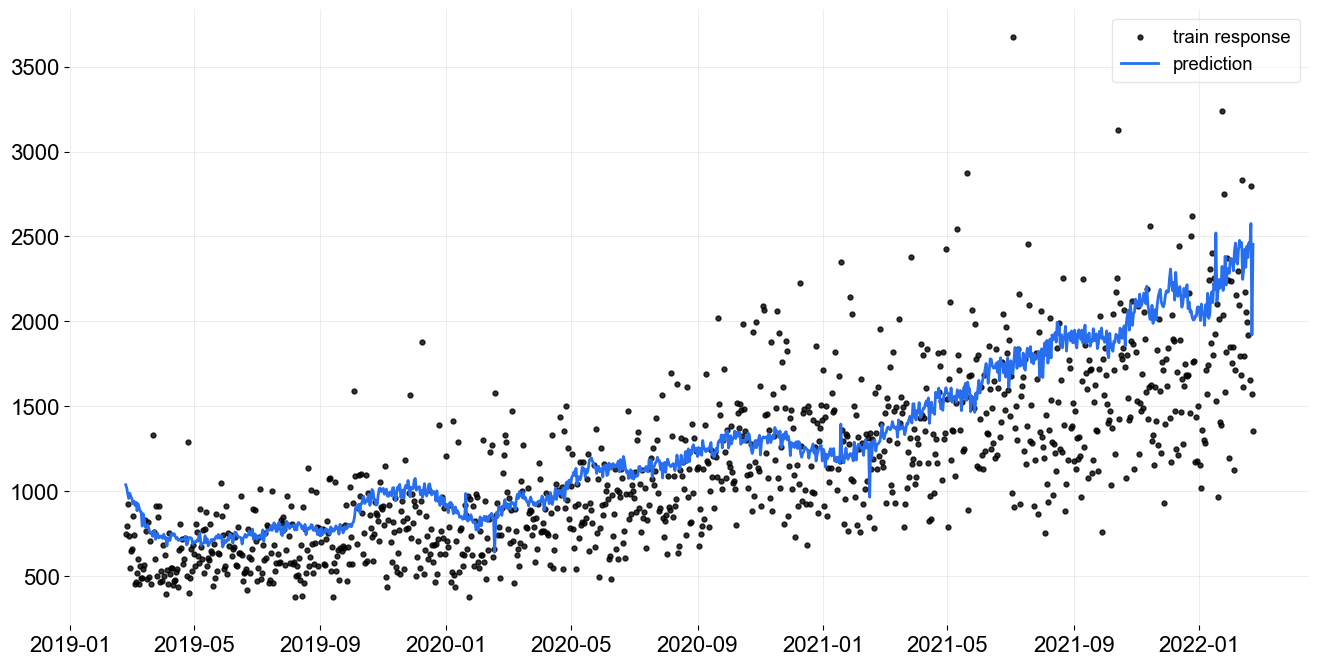

In [147]:
plot_predicted_data(
    training_actual_df=df,
    actual_col="sales",
    date_col="date",
    predicted_df=pred_df,
);

In [115]:
posteriors = mmm._model.get_posterior_samples()

In [116]:
np.median(posteriors['gb'], axis=0)

array([0.00084161])

In [117]:
from orbit.diagnostics.metrics import smape

In [118]:
prediction = pred_df["prediction"].values
actaul = df["sales"]
metrics = smape(actual=actaul, prediction=prediction)

In [120]:
mmm.best_params

{'damped_factor': 0.9057,
 'level_sm_input': 0.024499999999999966,
 'slope_sm_input': 0.09430000000000005}

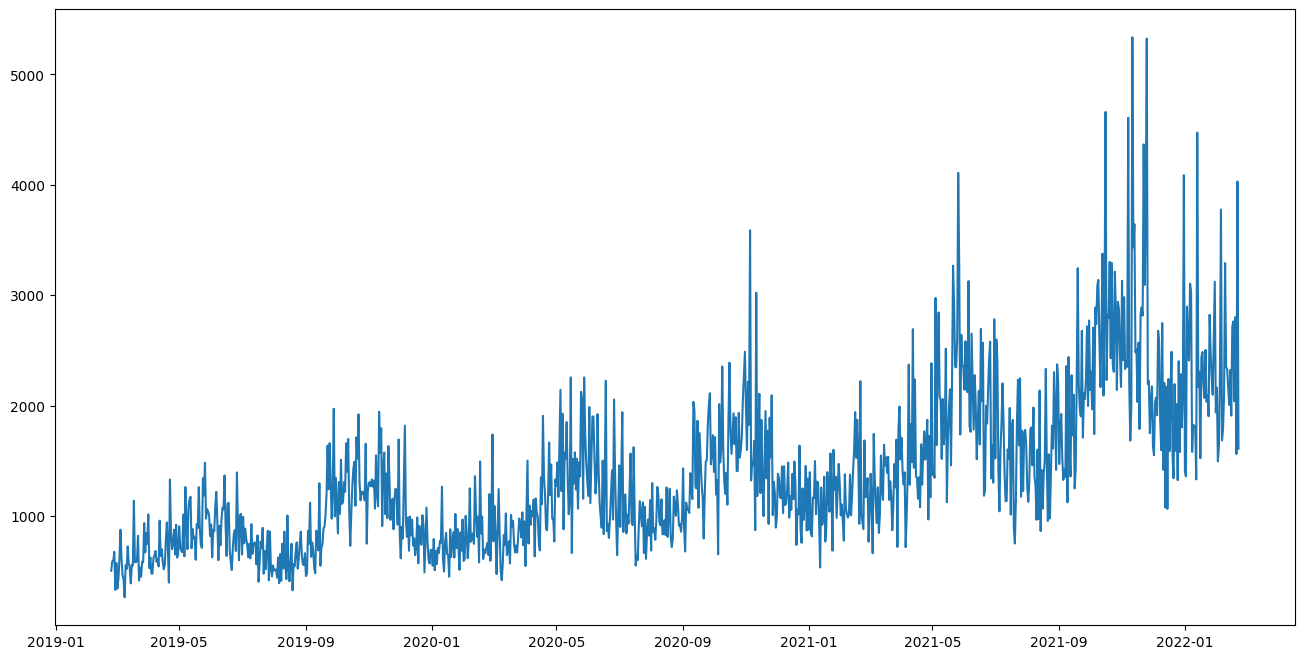

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(df["date"].values, df["sales"].values);

In [ ]:
# df.to_csv('data.csv', index=False)
# scalability_df.to_csv('scalability_df.csv', index=False)